In [1]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


In [2]:
import pandas as pd

df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [4]:
columns_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns_with_invalid_zeros:
    zero_count = (df[col] == 0).sum()
    print(f"{col}: {zero_count} zeros")

Glucose: 5 zeros
BloodPressure: 35 zeros
SkinThickness: 227 zeros
Insulin: 374 zeros
BMI: 11 zeros


In [5]:
for col in columns_with_invalid_zeros:
    median = df[col].median()
    df[col] = df[col].replace(0, median)

(df[columns_with_invalid_zeros] == 0).sum()

,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0


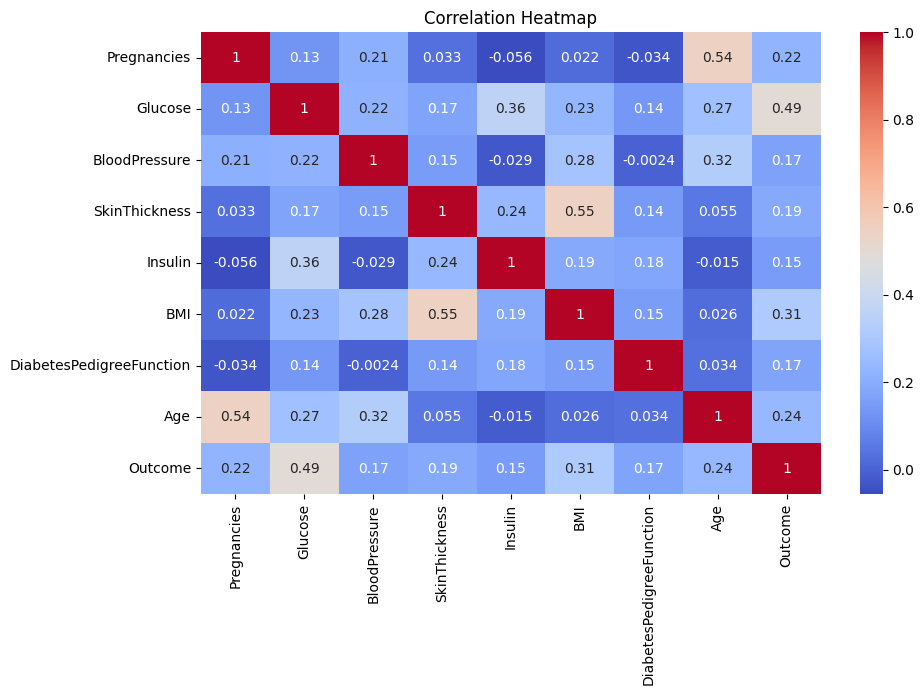

In [6]:
#EDA and Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

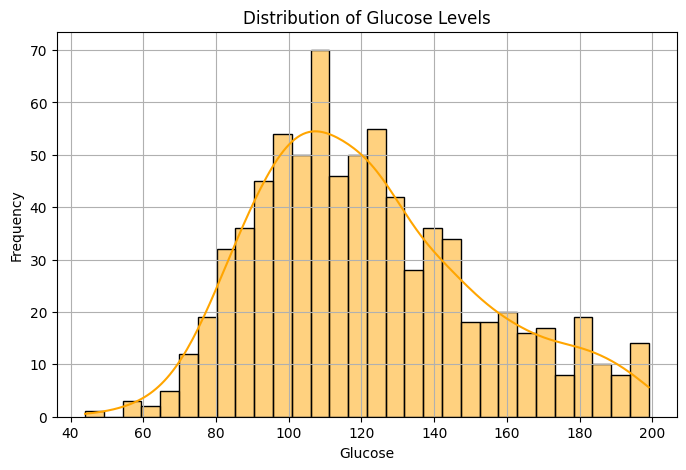

In [7]:
#Glucose distribution Histogram
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['Glucose'], bins=30, kde=True, color='orange')
plt.title('Distribution of Glucose Levels')
plt.xlabel('Glucose')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


/tmp/ipython-input-8-2086551765.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='Set2')


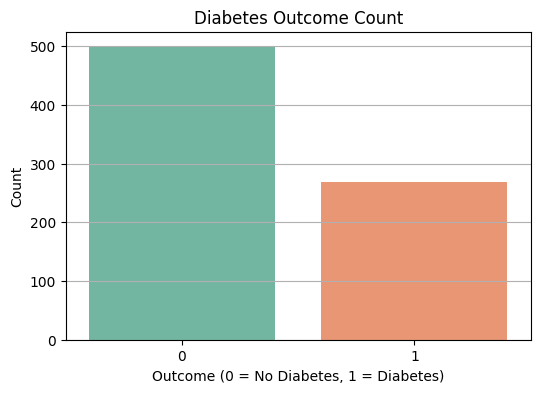

In [8]:
#Diabetes vs non-Diabetes count
plt.figure(figsize=(6, 4))
sns.countplot(x='Outcome', data=df, palette='Set2')
plt.title('Diabetes Outcome Count')
plt.xlabel('Outcome (0 = No Diabetes, 1 = Diabetes)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()


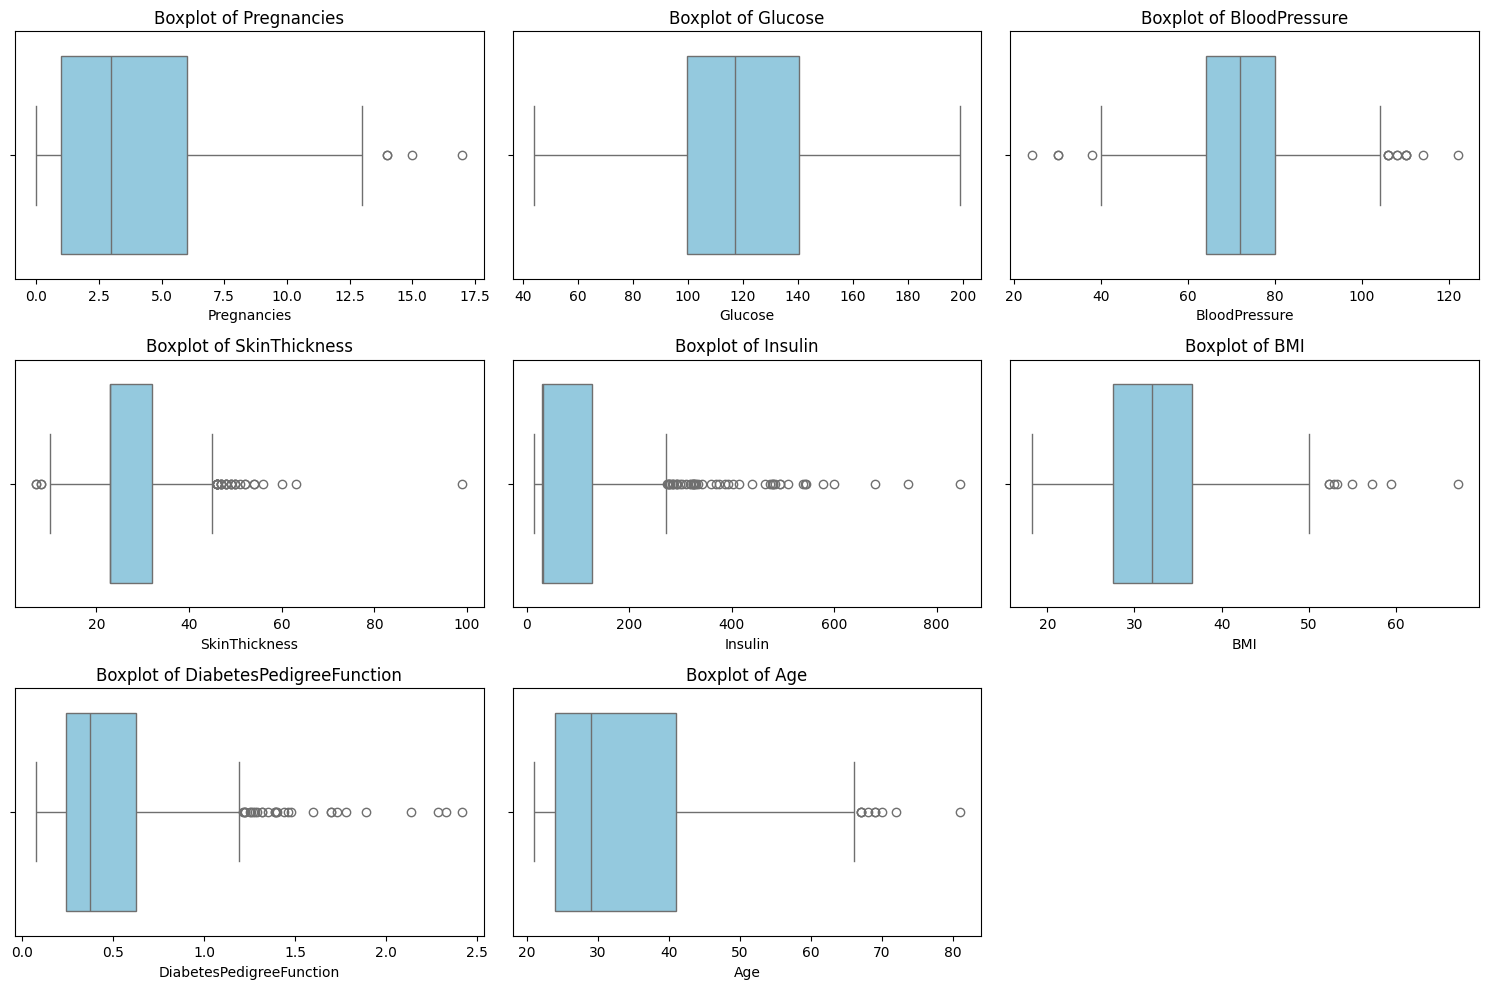

In [9]:
#Visualize Outliers with bloxplot

import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot grid
plt.figure(figsize=(15, 10))

# Create a boxplot for each numeric column
for i, column in enumerate(df.columns[:-1], 1):  # exclude 'Outcome'
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x=column, color='skyblue')
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [11]:
# Save zero-replaced data before removing outliers
df.to_csv('diabetes_zero_replaced.csv', index=False)

files.download("diabetes_zero_replaced.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply to all features except 'Outcome'
feature_columns = df.columns[df.columns != 'Outcome']
df_iqr_cleaned = remove_outliers_iqr(df, feature_columns)

print(f"Data shape after IQR outlier removal: {df_iqr_cleaned.shape}")

Data shape after IQR outlier removal: (615, 9)


In [13]:
#Save IQR-cleaned data
df_iqr_cleaned.to_csv('diabetes_iqr_cleaned.csv', index=False)

files.download("diabetes_iqr_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

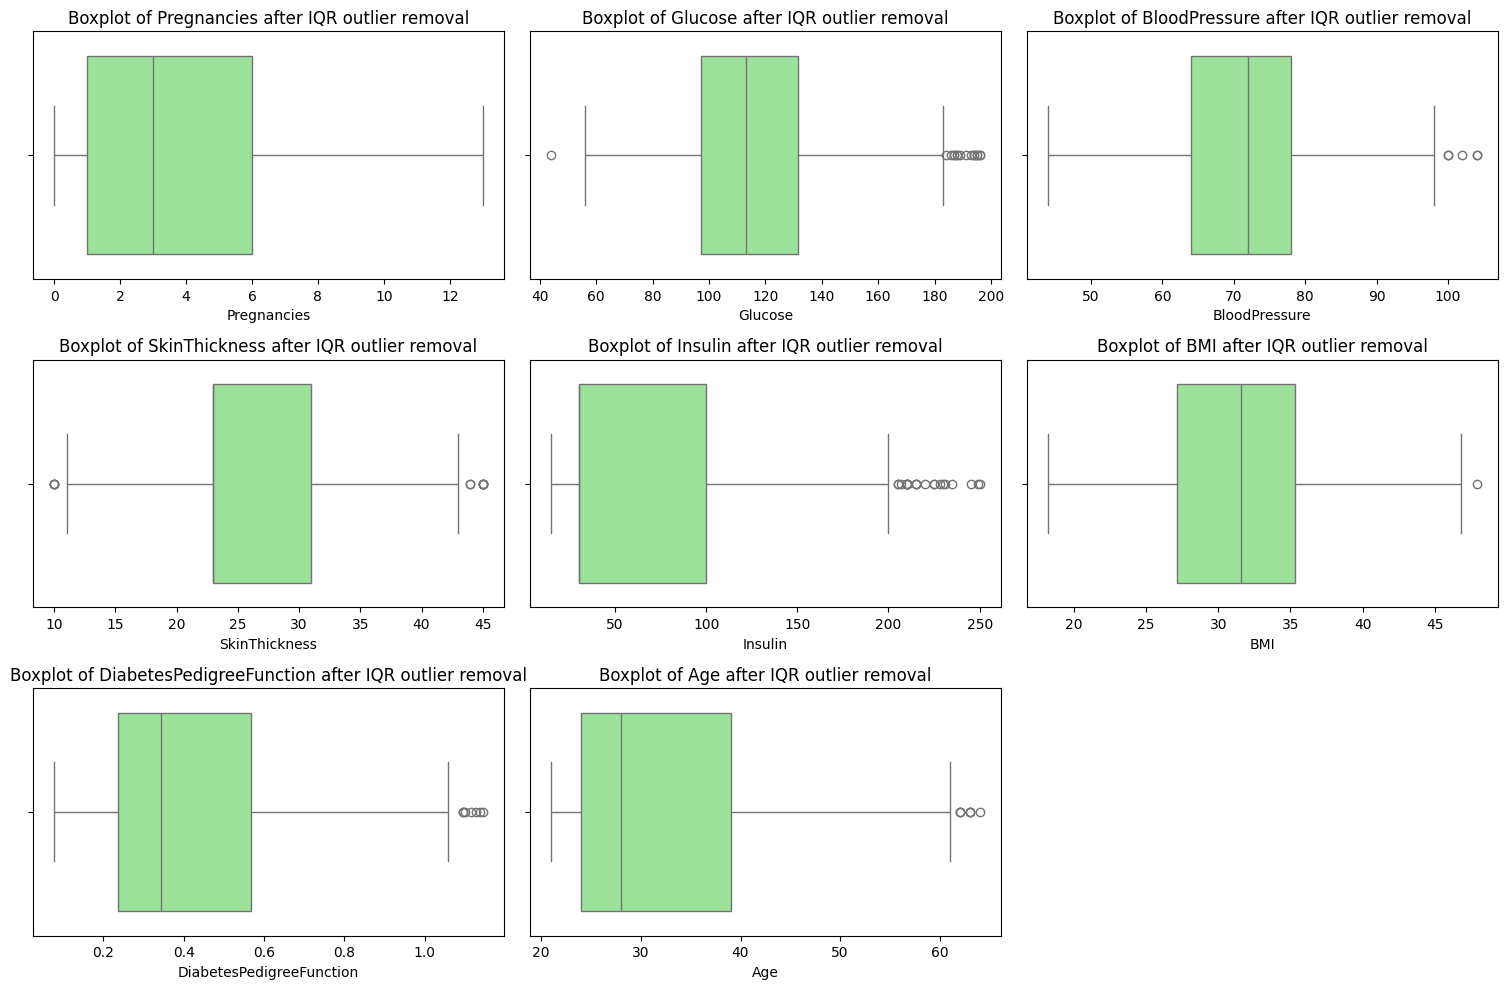

In [14]:
# Plot boxplots for the cleaned dataframe
plt.figure(figsize=(15, 10))

for i, column in enumerate(df_iqr_cleaned.columns[:-1], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df_iqr_cleaned, x=column, color='lightgreen')
    plt.title(f'Boxplot of {column} after IQR outlier removal')

plt.tight_layout()
plt.show()

In [15]:
print("Original df shape:", df.shape)
print("After IQR outlier removal:", df_iqr_cleaned.shape)


Original df shape: (768, 9)
After IQR outlier removal: (615, 9)


In [16]:
#Add Featuring to dataset

import pandas as pd
import pickle
import os

os.makedirs("data", exist_ok=True)

# Copy the cleaned DataFrame before binning
df_binned = df_iqr_cleaned.copy()

# ------------------ AGE BINNING ------------------
age_bins = [0, 19, 29, 39, 49, 59, 100]
age_labels = ['Teen', 'Young Adult', 'Adult', 'Middle-aged', 'Senior', 'Elderly']
df_binned['AgeGroup'] = pd.cut(df_binned['Age'], bins=age_bins, labels=age_labels, right=False)

# ------------------ BMI BINNING ------------------
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df_binned['BMIGroup'] = pd.cut(df_binned['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

# ------------------ ONE-HOT ENCODING ------------------
df_binned = pd.get_dummies(df_binned, columns=['AgeGroup', 'BMIGroup'])

# ------------------ SAVE BINNING CONFIG ------------------
bin_config = {
    "age_bins": age_bins,
    "age_labels": age_labels,
    "bmi_bins": bmi_bins,
    "bmi_labels": bmi_labels
}

with open("data/bin_config.pkl", "wb") as f:
    pickle.dump(bin_config, f)

# ------------------ SAVE FINAL BINNED DATA ------------------
df_binned.to_csv("data/diabetes_binned.csv", index=False)

# ------------------ SAVE COLUMN NAMES AFTER ENCODING ------------------
with open("data/columns.pkl", "wb") as f:
    pickle.dump(list(df_binned.columns), f)

# ------------------ SUMMARY ------------------
print("✅ Binning and one-hot encoding complete.")
print(f"🔢 Final shape: {df_binned.shape}")
print("📁 Binned data saved to: data/diabetes_binned.csv")
print("📦 Bin configuration saved to: data/bin_config.pkl")
print("🧩 Column list saved to: data/columns.pkl")
print(f"🧩 Columns: {list(df_binned.columns)}")

✅ Binning and one-hot encoding complete.
🔢 Final shape: (615, 19)
📁 Binned data saved to: data/diabetes_binned.csv
📦 Bin configuration saved to: data/bin_config.pkl
🧩 Column list saved to: data/columns.pkl
🧩 Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'AgeGroup_Teen', 'AgeGroup_Young Adult', 'AgeGroup_Adult', 'AgeGroup_Middle-aged', 'AgeGroup_Senior', 'AgeGroup_Elderly', 'BMIGroup_Underweight', 'BMIGroup_Normal', 'BMIGroup_Overweight', 'BMIGroup_Obese']


In [17]:
files.download("data/diabetes_binned.csv")
files.download("data/bin_config.pkl")
files.download("data/columns.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#Split dataset for training

from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import os

df = pd.read_csv("data/diabetes_binned.csv")

# Split into features and target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Save the splits to disk
os.makedirs("data/splits", exist_ok=True)

with open("data/splits/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("data/splits/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("data/splits/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("data/splits/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

# Summary
print("✅ Data split complete and saved.")
print(f"🧪 Training set: {X_train.shape}, {y_train.shape}")
print(f"🧾 Testing set: {X_test.shape}, {y_test.shape}")
print("📁 Splits saved to: data/splits/")

✅ Data split complete and saved.
🧪 Training set: (492, 18), (492,)
🧾 Testing set: (123, 18), (123,)
📁 Splits saved to: data/splits/


In [19]:
files.download("data/splits/X_train.pkl")
files.download("data/splits/X_test.pkl")
files.download("data/splits/y_train.pkl")
files.download("data/splits/y_test.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data Scaling before Training

In [22]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from google.colab import files

# Ensure folders exist
os.makedirs('model', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler for later use (e.g., in Streamlit app)
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Scaler fitted and saved as 'model/scaler.pkl'")

# Convert scaled data back to DataFrame with original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Add the target variable back
X_train_scaled_df['Outcome'] = y_train.reset_index(drop=True)

# Save scaled training data as CSV
csv_path = 'data/X_train_scaled.csv'
X_train_scaled_df.to_csv(csv_path, index=False)

print(f"✅ Scaled training data saved as '{csv_path}'")

# Download the scaler file
files.download('model/scaler.pkl')

# Download the scaled training data CSV
files.download(csv_path)


✅ Scaler fitted and saved as 'model/scaler.pkl'
✅ Scaled training data saved as 'data/X_train_scaled.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Models

In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [24]:
#Training Logistic Regression

logreg = LogisticRegression(max_iter=500, random_state=42)

# Cross-validation on training data (5-fold CV)
cv_scores_logreg = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Logistic Regression CV accuracy scores:", cv_scores_logreg)
print("Mean CV accuracy:", cv_scores_logreg.mean())

# Fit on full training data
logreg.fit(X_train_scaled, y_train)

# Predict on test set (scale X_test as well!)
X_test_scaled = scaler.transform(X_test)  # Use saved scaler to transform test data
y_pred_logreg = logreg.predict(X_test_scaled)

# Evaluate test accuracy
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression test accuracy: {acc_logreg:.4f}")

# Confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))


Logistic Regression CV accuracy scores: [0.81818182 0.75757576 0.75510204 0.80612245 0.81632653]
Mean CV accuracy: 0.7906617192331479
Logistic Regression test accuracy: 0.7642
Confusion Matrix:
 [[74 11]
 [18 20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.84        85
           1       0.65      0.53      0.58        38

    accuracy                           0.76       123
   macro avg       0.72      0.70      0.71       123
weighted avg       0.76      0.76      0.76       123



In [25]:
# Random Forest Training
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation on training data
cv_scores_rf = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print("Random Forest CV accuracy scores:", cv_scores_rf)
print("Mean CV accuracy:", cv_scores_rf.mean())

# Fit on full training data
rf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test_scaled)

# Evaluate test accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest test accuracy: {acc_rf:.4f}")

# Confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest CV accuracy scores: [0.78787879 0.80808081 0.73469388 0.7244898  0.83673469]
Mean CV accuracy: 0.778375592661307
Random Forest test accuracy: 0.7724
Confusion Matrix:
 [[77  8]
 [20 18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.91      0.85        85
           1       0.69      0.47      0.56        38

    accuracy                           0.77       123
   macro avg       0.74      0.69      0.70       123
weighted avg       0.76      0.77      0.76       123



Trying to train Logreg, RF and SVM at once

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Dictionary to store results
results = {}

for model_name, model in models.items():
    # Cross-validated predictions on training set for better generalization check
    y_train_pred = cross_val_predict(model, X_train_scaled, y_train, cv=5)

    # Metrics
    accuracy = accuracy_score(y_train, y_train_pred)
    precision = precision_score(y_train, y_train_pred)
    recall = recall_score(y_train, y_train_pred)
    f1 = f1_score(y_train, y_train_pred)

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    results[model_name] = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }



Model: Logistic Regression
Accuracy: 0.7907
Precision: 0.6992
Recall: 0.5658
F1-Score: 0.6255

Model: Random Forest
Accuracy: 0.7785
Precision: 0.6748
Recall: 0.5461
F1-Score: 0.6036

Model: SVM
Accuracy: 0.7744
Precision: 0.6847
Recall: 0.5000
F1-Score: 0.5779


In [27]:
#Increase Logistic Regression iterations and add class weighting to handle imbalance:

from sklearn.model_selection import cross_val_score

# Logistic Regression with class weights (heavier for class 1)
logreg = LogisticRegression(max_iter=2000, class_weight={0:1, 1:3}, random_state=42)

cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='recall')
print("CV Recall scores with class weighting:", cv_scores)
print("Mean CV Recall:", cv_scores.mean())


CV Recall scores with class weighting: [0.83870968 0.80645161 0.86666667 0.76666667 0.83333333]
Mean CV Recall: 0.8223655913978494


In [28]:
#Train Logistic Regression on full training set and test:
logreg.fit(X_train_scaled, y_train)
y_test_pred = logreg.predict(X_test_scaled)

from sklearn.metrics import classification_report, confusion_matrix

print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79        85
           1       0.55      0.71      0.62        38

    accuracy                           0.73       123
   macro avg       0.70      0.73      0.71       123
weighted avg       0.76      0.73      0.74       123

Confusion Matrix:
[[63 22]
 [11 27]]


In [29]:
#Adjust Decision Threshold for better results
import numpy as np
from sklearn.metrics import classification_report

y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Lower threshold from 0.5 to 0.3
threshold = 0.3
y_pred_adj = (y_proba >= threshold).astype(int)

print("Classification Report with threshold 0.3:")
print(classification_report(y_test, y_pred_adj))


Classification Report with threshold 0.3:
              precision    recall  f1-score   support

           0       0.93      0.51      0.66        85
           1       0.45      0.92      0.61        38

    accuracy                           0.63       123
   macro avg       0.69      0.71      0.63       123
weighted avg       0.79      0.63      0.64       123



In [31]:
#Adjust Decision Threshold for better results
import numpy as np
from sklearn.metrics import classification_report

y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# threshold from 0.3 to 0.4
threshold = 0.4
y_pred_adj = (y_proba >= threshold).astype(int)

print("Classification Report with threshold 0.4:")
print(classification_report(y_test, y_pred_adj))


Classification Report with threshold 0.4:
              precision    recall  f1-score   support

           0       0.89      0.64      0.74        85
           1       0.50      0.82      0.62        38

    accuracy                           0.69       123
   macro avg       0.69      0.73      0.68       123
weighted avg       0.77      0.69      0.70       123



In [32]:
#Defining the best model as Loistic Regression for now before further testing

from sklearn.linear_model import LogisticRegression

best_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Fit on scaled training data
best_model.fit(X_train_scaled, y_train)

# Predict on test set (for confirmation)
y_test_pred = best_model.predict(X_test_scaled)

# Print classification report
from sklearn.metrics import classification_report
print("Best Model (Logistic Regression with class_weight='balanced') Report:")
print(classification_report(y_test, y_test_pred))


Best Model (Logistic Regression with class_weight='balanced') Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.80        85
           1       0.57      0.66      0.61        38

    accuracy                           0.74       123
   macro avg       0.70      0.72      0.71       123
weighted avg       0.75      0.74      0.74       123



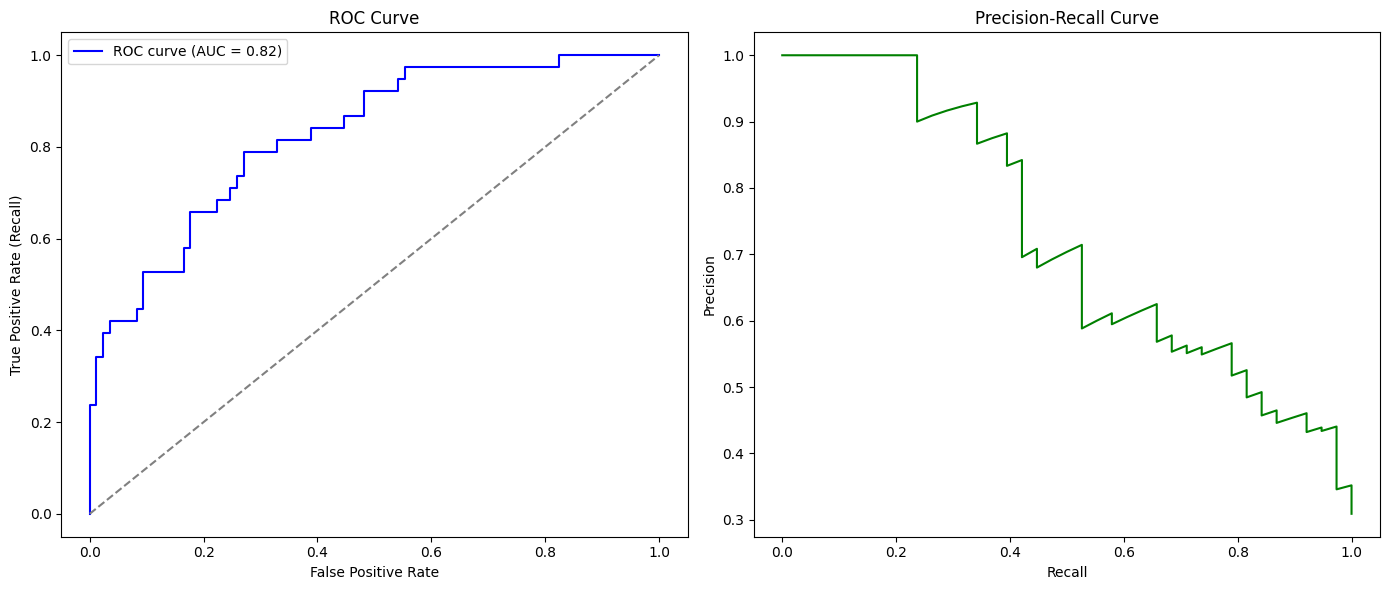

In [33]:
#Plot Evaluation Curves

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plotting both
plt.figure(figsize=(14, 6))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


AUC around 0.8 or higher if Model is good.

| AUC Score     | Interpretation          |
| ------------- | ----------------------- |
| 0.5           | Random guessing 🚫      |
| 0.6 - 0.7     | Poor/Fair               |
| 0.7 - 0.8     | Good 👍                 |
| **0.8 - 0.9** | **Excellent ✅**         |
| 0.9 - 1.0     | Suspiciously perfect 🤖 |

https://pmc.ncbi.nlm.nih.gov/articles/PMC10664195/

In [34]:
#Logistic Regression Hyperparameter Tuning with GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # only solver supporting both l1 and l2
}

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Best estimator
best_logreg = grid_search.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [35]:
#Evaluate This Best Model on Test Set

from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set using best tuned model
y_test_pred = best_logreg.predict(X_test_scaled)

# Report
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        85
           1       0.55      0.76      0.64        38

    accuracy                           0.73       123
   macro avg       0.71      0.74      0.71       123
weighted avg       0.77      0.73      0.74       123

Confusion Matrix:
[[61 24]
 [ 9 29]]


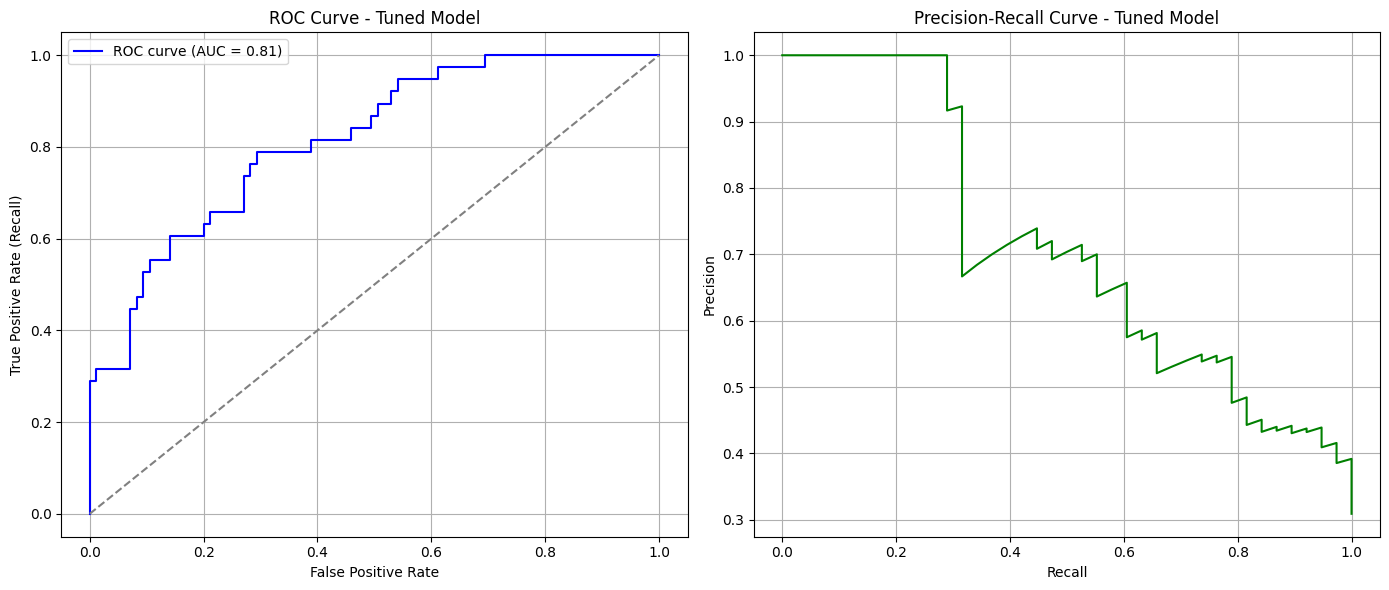

In [36]:
#AUC Plot with gridsearch tuned values

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# Use the best estimator from GridSearchCV
best_model = grid_search.best_estimator_

# Predict probabilities on the scaled test data
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plotting both curves
plt.figure(figsize=(14, 6))

# ROC Curve subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Tuned Model')
plt.legend()
plt.grid(True)

# Precision-Recall Curve subplot
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Tuned Model')
plt.grid(True)

plt.tight_layout()
plt.show()


Default Tuning got AUC = 8.2 unlike this.. But Precision recall seems to be better here.

In [37]:
#SAving and Downloading the model

import pickle

# Save the trained model
with open("data/best_logistic_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save the scaler used on the data
with open("data/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Model and scaler saved successfully.")


files.download('data/best_logistic_model.pkl')
files.download('data/scaler.pkl')


✅ Model and scaler saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>